Loading and preprocessing data...
Initial data shape: (32561, 15)

=== 预处理后的数据统计信息 ===

1. 数值特征统计:
                age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         

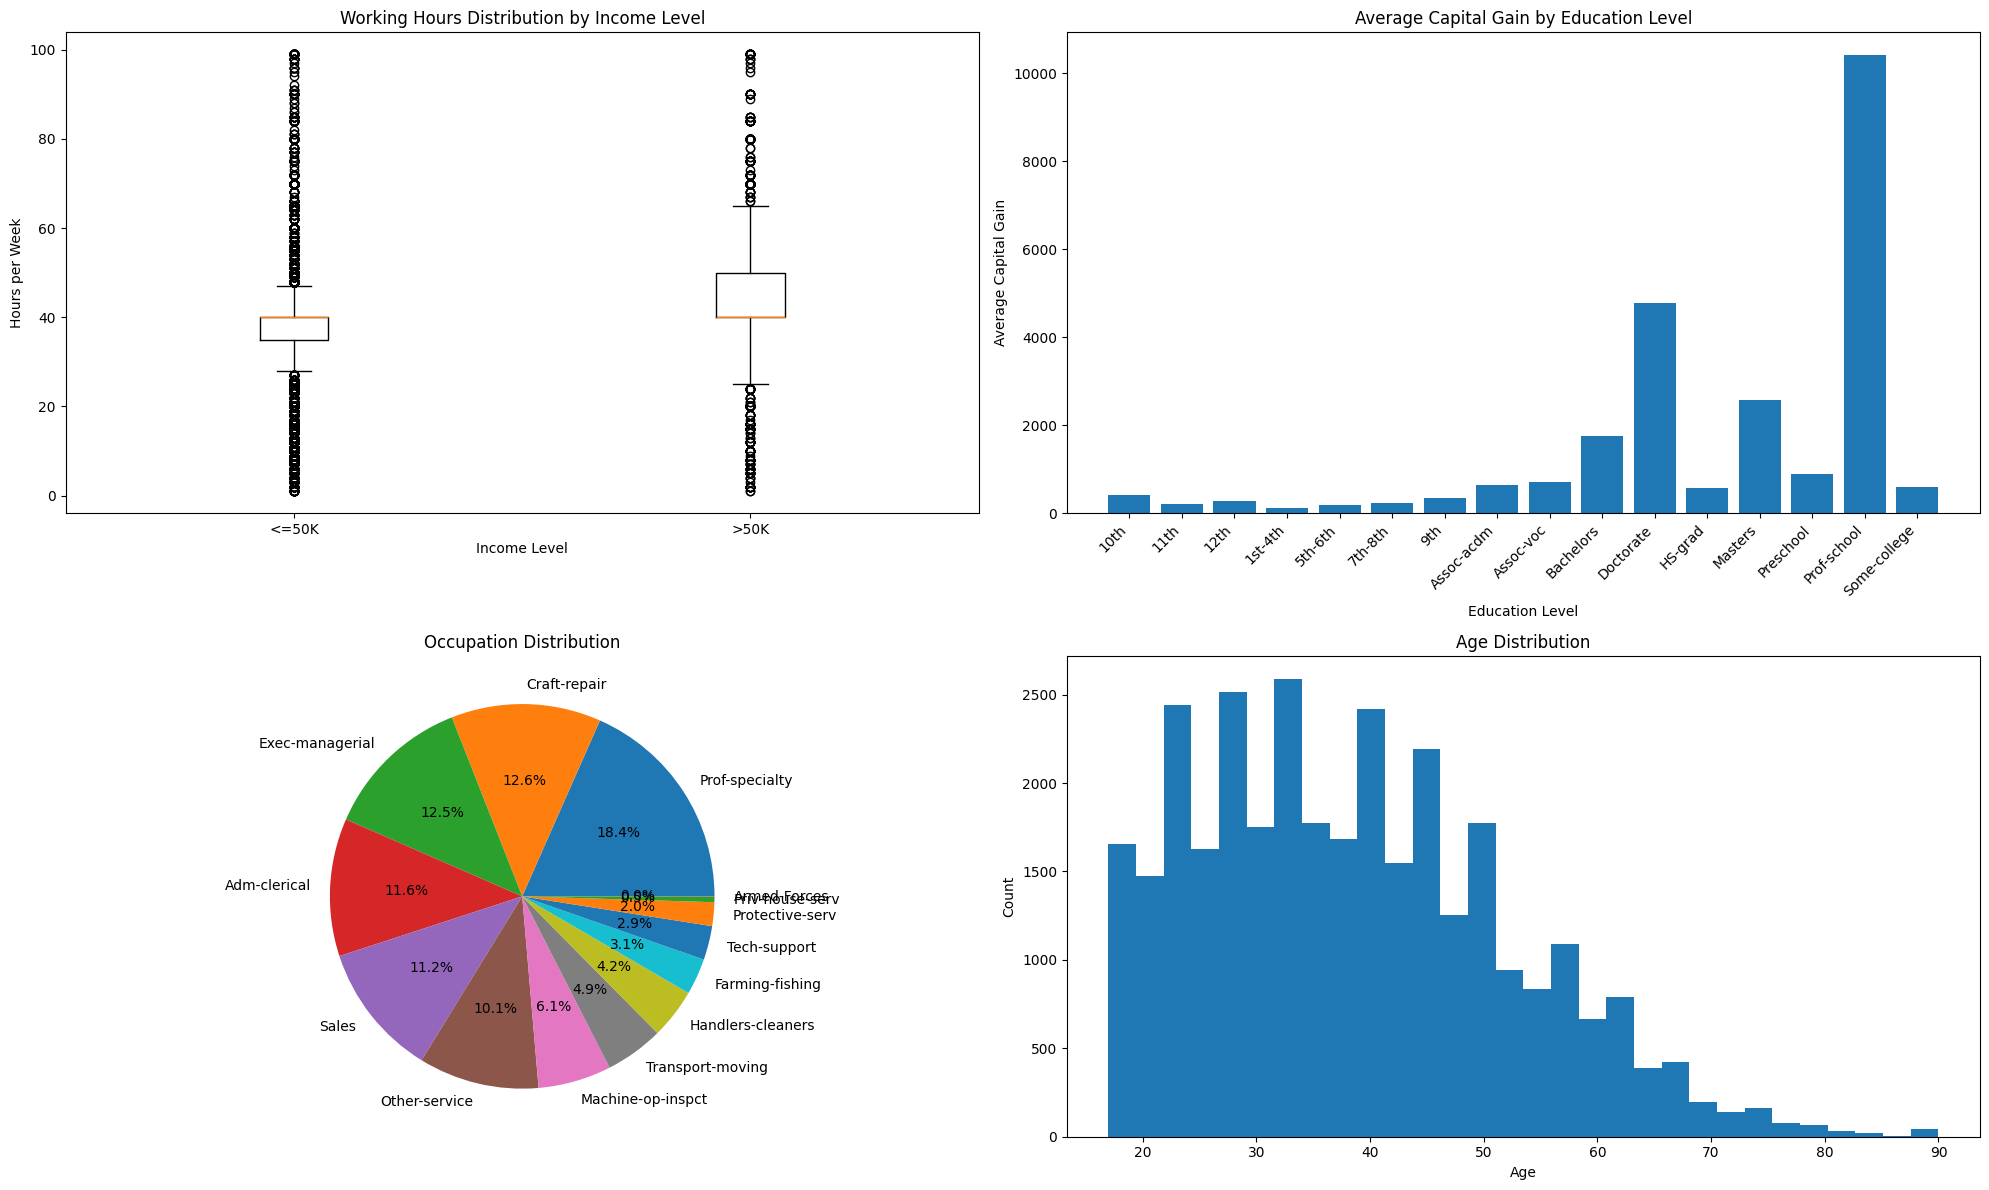


=== 特征相关性分析 ===

高相关性特征对 (|相关系数| > 0.5):
relationship - sex: -0.582
sex - relationship: -0.582
capital-gain - income_per_hour: 0.888
capital-gain - total_capital: 0.999
income_per_hour - capital-gain: 0.888
income_per_hour - total_capital: 0.886
total_capital - capital-gain: 0.999
total_capital - income_per_hour: 0.886

Training Random Forest Classifier...

Cross-validation scores: [0.8571977  0.86449136 0.86257198 0.86388942 0.86907276]
Average CV score: 0.8634 (+/- 0.0076)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      4942
           1       0.79      0.64      0.71      1571

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513



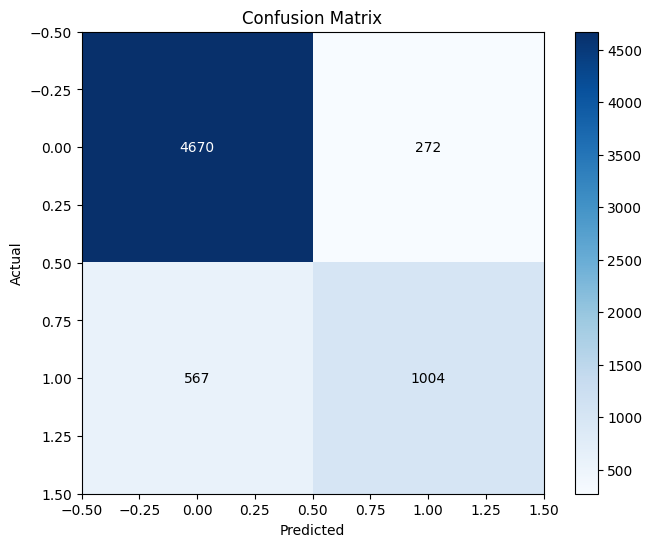


Test set accuracy: 0.8712

Analyzing feature importance...


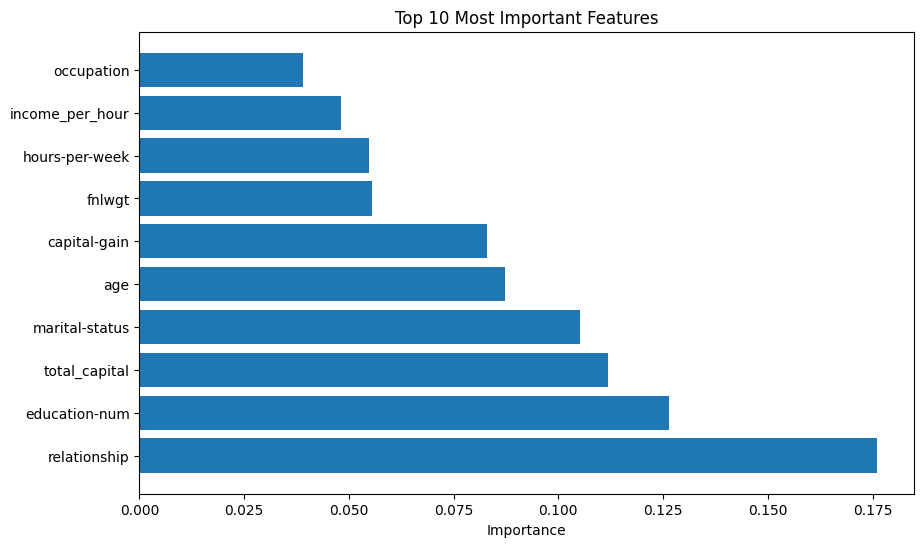


Top 5 most important features:
           feature  importance
7     relationship    0.176175
4    education-num    0.126410
15   total_capital    0.111792
5   marital-status    0.105133
0              age    0.087383


In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
# 使用 inline 后端，适用于 Jupyter Notebook
%matplotlib inline
from sklearn.feature_selection import SelectKBest, f_classif

def load_adult_data():
    try:
        # 定义列名
        columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
                   'marital-status', 'occupation', 'relationship', 'race', 'sex',
                   'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
        
        # 加载数据，使用正确的分隔符和空格处理
        df = pd.read_csv('adult.data', names=columns, sep=',', engine='python', 
                        skipinitialspace=True, na_values=[' ?', '?'])
        print(f"Initial data shape: {df.shape}")
        
        # 清理数据中的空格和特殊字符
        for column in df.columns:
            if df[column].dtype == 'object':
                df[column] = df[column].str.strip()
        
        # 对分类变量使用众数填充
        categorical_columns = ['workclass', 'education', 'marital-status', 'occupation',
                             'relationship', 'race', 'sex', 'native-country']
        for col in categorical_columns:
            if df[col].isnull().any():
                df = df.copy()
                df[col] = df[col].fillna(df[col].mode()[0])
        
        # 对数值变量使用中位数填充
        numeric_columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 
                         'capital-loss', 'hours-per-week']
        for col in numeric_columns:
            if df[col].isnull().any():
                df[col].fillna(df[col].median(), inplace=True)
        
        # 在数据预处理后立即输出基本统计信息
        print("\n=== 预处理后的数据统计信息 ===")
        
        print("\n1. 数值特征统计:")
        print(df[numeric_columns].describe())
        
        print("\n2. 分类特征分布:")
        for col in categorical_columns:
            print(f"\n{col} 的分布 (前5类):")
            print(df[col].value_counts().head())
        
        print("\n3. 目标变量(income)分布:")
        print(df['income'].value_counts())
        
        # 在编码之前保存原始数据副本用于可视化
        df_original = df.copy()
        
        # 添加新的数据可视化
        print("\nGenerating business insights visualizations...")
        visualize_business_insights(df_original)
        
        # 特征工程
        df['income_per_hour'] = df['capital-gain'] / (df['hours-per-week'] + 1)
        df['total_capital'] = df['capital-gain'] - df['capital-loss']
        
        # 标准化数值特征
        scaler = StandardScaler()
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
        
        # 编码分类变量
        label_encoders = {}
        for column in categorical_columns:
            label_encoders[column] = LabelEncoder()
            df[column] = label_encoders[column].fit_transform(df[column])
        
        # 准备特征和标签
        X = df.drop('income', axis=1)
        y = LabelEncoder().fit_transform(df['income'])
        
        # 现在所有特征都是数值型的，可以计算相关性
        print("\n=== 特征相关性分析 ===")
        correlation_matrix = X.corr()
        # 显示相关系数绝对值大于0.5的特征对
        high_corr = np.where(np.abs(correlation_matrix) > 0.5)
        high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], 
                      correlation_matrix.iloc[x, y]) 
                     for x, y in zip(*high_corr) if x != y]
        if high_corr:
            print("\n高相关性特征对 (|相关系数| > 0.5):")
            for feat1, feat2, corr in high_corr:
                print(f"{feat1} - {feat2}: {corr:.3f}")
        
        return X, y, label_encoders
        
    except Exception as e:
        print(f"Error in data loading: {str(e)}")
        raise

def visualize_business_insights(df):
    """商业数据分析可视化"""
    try:
        plt.style.use('default')
        
        fig = plt.figure(figsize=(20, 12))
        
        # 1. 收入水平与工作时间的关系
        plt.subplot(2, 2, 1)
        income_levels = df['income'].unique()
        data = [df[df['income'] == income]['hours-per-week'].values 
                for income in income_levels]
        plt.boxplot(data, tick_labels=income_levels)
        plt.title('Working Hours Distribution by Income Level')
        plt.xlabel('Income Level')
        plt.ylabel('Hours per Week')
        
        # 2. 教育程度与资本收益的关系
        plt.subplot(2, 2, 2)
        education_capital = df.groupby('education')['capital-gain'].mean()
        x = range(len(education_capital))
        plt.bar(x, education_capital.values)
        plt.xticks(x, education_capital.index, rotation=45, ha='right')
        plt.title('Average Capital Gain by Education Level')
        plt.xlabel('Education Level')
        plt.ylabel('Average Capital Gain')
        
        # 3. 职业分布
        plt.subplot(2, 2, 3)
        occupation_counts = df['occupation'].value_counts()
        plt.pie(occupation_counts.values, labels=occupation_counts.index, autopct='%1.1f%%')
        plt.title('Occupation Distribution')
        
        # 4. 年龄��布
        plt.subplot(2, 2, 4)
        plt.hist(df['age'], bins=30)
        plt.title('Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Count')
        
        plt.tight_layout()
        plt.show()  # 直接显示而不是保存
        
    except Exception as e:
        print(f"Error in visualization: {str(e)}")

def analyze_feature_importance(model, X, feature_names):
    """分析特征重要性"""
    try:
        importances = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(10), importances['importance'][:10])
        plt.yticks(range(10), importances['feature'][:10])
        plt.title('Top 10 Most Important Features')
        plt.xlabel('Importance')
        plt.show()  # 直接显示而不是保存
        
        return importances
        
    except Exception as e:
        print(f"Error in feature importance analysis: {str(e)}")
        return None

def evaluate_model(model, X_test, y_test, y_pred):
    """评估模型性能"""
    try:
        # 打印分类报告
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # 混淆矩阵可视化
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        # 添加数值标签
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i, j] > cm.max()/2 else "black")
        
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()  # 直接显示而不是保存
        
        # 计算并返回准确率
        accuracy = (y_test == y_pred).mean()
        return accuracy
        
    except Exception as e:
        print(f"Error in model evaluation: {str(e)}")
        return None

def main():
    # 加载数据和预处理
    print("Loading and preprocessing data...")
    X, y, label_encoders = load_adult_data()
    
    # 分割训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 训练随机森林模型
    print("\nTraining Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    
    # 交叉验证
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # 在测试集上预测和评估
    y_pred = rf_model.predict(X_test)
    accuracy = evaluate_model(rf_model, X_test, y_test, y_pred)
    print(f"\nTest set accuracy: {accuracy:.4f}")
    
    # 分析特征重要性
    print("\nAnalyzing feature importance...")
    feature_importance = analyze_feature_importance(rf_model, X, X.columns)
    print("\nTop 5 most important features:")
    print(feature_importance.head())
    
    # 保存模型（可选）
    # import joblib
    # joblib.dump(rf_model, 'random_forest_model.joblib')
    # joblib.dump(label_encoders, 'label_encoders.joblib')

if __name__ == "__main__":
    main() 